In [1]:
from Model import *
from ForwardTime import *
from Source import *
from Receiver import *
from Operator import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Solver():
    # data 
    
    # function
    # 
    # tag = saving all field data or not
    def __init__(self, ft, model, source, receiver, op, tag):
        self._ft = ft
        self._model = model
        self._source = source
        self._receiver = receiver
        self._op = op
        self._tag = tag
        
        nx = model._array_size[0]
        nz = model._array_size[1]
        nt = ft._nt
        
        if tag==True:
            self._vx = np.zeros((nx, nz, nt), dtype=np.float32)
            self._vz = np.zeros((nx, nz, nt), dtype=np.float32)        
        
    def execute(self,):
        if self._model._type == 'normal':
            if self._op._to == 2:
                self.older2_normal()
            elif self._op._to == 4:
                self.older4_normal()
            else:
                print("only support for 2 or 4 older in time Now")
                return 1
        elif self._model._type == 'pml':
            if self._op._to == 2:
                self.older2_pml()
            elif self._op._to == 4:
                self.older4_pml()
            else:
                print("only support for 2 or 4 older in time Now")
                return 1
        else:
            print("undefined model type")
            return 1
        
    def older2_normal(self,):
        # some basic info
        time_array = self._ft._t_array
        array_size = self._model._array_size
        tag = self._tag
        source_array = self._source._sa
        source_direction = self._source._direction
        source_position = self._source._position
                
        # Intermediate variable
        u = np.zeros(array_size, dtype=np.float32)
        v = np.zeros(array_size, dtype=np.float32)
        r = np.zeros(array_size, dtype=np.float32)
        t = np.zeros(array_size, dtype=np.float32)
        h = np.zeros(array_size, dtype=np.float32)
        
        for tk, tt in enumerate(time_array):
            if tk >= 1: # No computing in the first step
                
                u_x = self._op.compute_u_x(u)
                u_z = self._op.compute_u_z(u)
                v_x = self._op.compute_v_x(v)
                v_z = self._op.compute_v_z(v)
                                
                r = self.older2_compute_r(r, u_x, v_z)
                t = self.older2_compute_t(t, u_x, v_z)
                h = self.older2_compute_h(h, v_x, u_z)
                
                r_x = self._op.compute_r_x(r)
                t_z = self._op.compute_t_z(t)
                h_x = self._op.compute_h_x(h)
                h_z = self._op.compute_h_z(h)
                
                u = self.older2_compute_u(u, r_x, h_z)
                v = self.older2_compute_v(v, t_z, h_x)
                
            if tk < len(source_array):
                if source_direction=='x':
                    u[source_position[0],source_position[1]] += source_array[tk]
                else:
                    v[source_position[0],source_position[1]] += source_array[tk]
                
            if tag == True:
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
                    
            for item in self._receiver:
                item._rax[tk] = u[item._position[0], item._position[1]]
                item._raz[tk] = v[item._position[0], item._position[1]]
            
            if np.max(u)>20:
                print("Divergent! Please check and reset grid spacing or/and time step length")
                return
        
    def older4_normal(self,):
        # some basic info
        time_array = self._ft._t_array
        array_size = self._model._array_size
        tag = self._tag
        source_array = self._source._sa
        source_direction = self._source._direction
        source_position = self._source._position
                
        # Intermediate variable
        u = np.zeros(array_size, dtype=np.float32)
        v = np.zeros(array_size, dtype=np.float32)
        r = np.zeros(array_size, dtype=np.float32)
        t = np.zeros(array_size, dtype=np.float32)
        h = np.zeros(array_size, dtype=np.float32)
        
        for tk, tt in enumerate(time_array):
            if tk >= 1: # No computing in the first step
                
                u_x = self._op.compute_u_x(u)
                u_z = self._op.compute_u_z(u)
                v_x = self._op.compute_v_x(v)
                v_z = self._op.compute_v_z(v)
                                
                r = self.older4_compute_r(u, v, r, u_x, v_z)
                t = self.older4_compute_t(u, v, t, u_x, v_z)
                h = self.older4_compute_h(u, v, h, v_x, u_z)
                
                r_x = self._op.compute_r_x(r)
                t_z = self._op.compute_t_z(t)
                h_x = self._op.compute_h_x(h)
                h_z = self._op.compute_h_z(h)
                
                u = self.older4_compute_u(u, r, t, h, r_x, h_z)
                v = self.older4_compute_v(v, r, t, h, h_x, t_z)
                
            if tk < len(source_array):
                if source_direction=='x':
                    u[source_position[0],source_position[1]] += source_array[tk]
                else:
                    v[source_position[0],source_position[1]] += source_array[tk]
                
            if tag == True:
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
                    
            for item in self._receiver:
                item._rax[tk] = u[item._position[0], item._position[1]]
                item._raz[tk] = v[item._position[0], item._position[1]]
            
            if np.max(u)>20:
                print("Divergent! Please check and reset grid spacing or/and time step length")
                return
            
    def older2_pml(self):
        
        # some basic info
        time_array = self._ft._t_array
        array_size = self._model._array_size
        tag = self._tag
        source_array = self._source._sa
        source_direction = self._source._direction
        source_position = self._source._position
                
        # Intermediate variable
        u = np.zeros(array_size, dtype=np.float32)
        v = np.zeros(array_size, dtype=np.float32)
        r = np.zeros(array_size, dtype=np.float32)
        t = np.zeros(array_size, dtype=np.float32)
        h = np.zeros(array_size, dtype=np.float32)

        omega_xx = np.zeros(array_size, dtype=np.float32)
        omega_xz = np.zeros(array_size, dtype=np.float32)
        omega_zx = np.zeros(array_size, dtype=np.float32)
        omega_zz = np.zeros(array_size, dtype=np.float32)
        phi_xx = np.zeros(array_size, dtype=np.float32)
        phi_zz = np.zeros(array_size, dtype=np.float32)
        phi_zx = np.zeros(array_size, dtype=np.float32)
        phi_xz = np.zeros(array_size, dtype=np.float32)

        for tk, tt in enumerate(time_array):
            if tk >= 1: # No computing in the first step
                
                u_x = self._op.compute_u_x(u)
                u_z = self._op.compute_u_z(u)
                v_x = self._op.compute_v_x(v)
                v_z = self._op.compute_v_z(v)
                                
                r = self.older2_pml_compute_r(r, u_x, v_z, phi_xx, phi_zz)
                t = self.older2_pml_compute_t(t, u_x, v_z, phi_xx, phi_zz)
                h = self.older2_pml_compute_h(h, v_x, u_z, phi_zx, phi_xz)
                
                r_x = self._op.compute_r_x(r)
                t_z = self._op.compute_t_z(t)
                h_x = self._op.compute_h_x(h)
                h_z = self._op.compute_h_z(h)
                
                # omega update
                omega_xx = self.cal_omega_xx(r_x, omega_xx)
                omega_xz = self.cal_omega_xz(h_z, omega_xz)
                omega_zx = self.cal_omega_zx(h_x, omega_zx)
                omega_zz = self.cal_omega_zz(t_z, omega_zz)
                
                u = self.older2_pml_compute_u(u, r_x, h_z, omega_xx, omega_xz)
                v = self.older2_pml_compute_v(v, h_x, t_z, omega_zx, omega_zz)
                
                # phi update
                phi_xx = self.cal_phi_xx(u_x, phi_xx)
                phi_zz = self.cal_phi_zz(v_z, phi_zz)
                phi_zx = self.cal_phi_zx(v_x, phi_zx)
                phi_xz = self.cal_phi_xz(u_z, phi_xz)

            if tk < len(source_array):
                if source_direction=='x':
                    u[source_position[0],source_position[1]] += source_array[tk]
                else:
                    v[source_position[0],source_position[1]] += source_array[tk]
                
            if tag == True:
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
                    
            for item in self._receiver:
                item._rax[tk] = u[item._position[0], item._position[1]]
                item._raz[tk] = v[item._position[0], item._position[1]]
            
            if np.max(u)>20:
                print("Divergent! Please check and reset grid spacing or/and time step length")
                return
            
            
    def older4_pml(self):
        
        # some basic info
        time_array = self._ft._t_array
        array_size = self._model._array_size
        tag = self._tag
        source_array = self._source._sa
        source_direction = self._source._direction
        source_position = self._source._position
                
        # Intermediate variable
        u = np.zeros(array_size, dtype=np.float32)
        v = np.zeros(array_size, dtype=np.float32)
        r = np.zeros(array_size, dtype=np.float32)
        t = np.zeros(array_size, dtype=np.float32)
        h = np.zeros(array_size, dtype=np.float32)

        omega_xx = np.zeros(array_size, dtype=np.float32)
        omega_xz = np.zeros(array_size, dtype=np.float32)
        omega_zx = np.zeros(array_size, dtype=np.float32)
        omega_zz = np.zeros(array_size, dtype=np.float32)
        phi_xx = np.zeros(array_size, dtype=np.float32)
        phi_zz = np.zeros(array_size, dtype=np.float32)
        phi_zx = np.zeros(array_size, dtype=np.float32)
        phi_xz = np.zeros(array_size, dtype=np.float32)

        for tk, tt in enumerate(time_array):
            if tk >= 1: # No computing in the first step
                
                u_x = self._op.compute_u_x(u)
                u_z = self._op.compute_u_z(u)
                v_x = self._op.compute_v_x(v)
                v_z = self._op.compute_v_z(v)
                                
                r = self.older2_pml_compute_r(r, u_x, v_z, phi_xx, phi_zz)
                t = self.older2_pml_compute_t(t, u_x, v_z, phi_xx, phi_zz)
                h = self.older2_pml_compute_h(h, v_x, u_z, phi_zx, phi_xz)
                
                r_x = self._op.compute_r_x(r)
                t_z = self._op.compute_t_z(t)
                h_x = self._op.compute_h_x(h)
                h_z = self._op.compute_h_z(h)
                
                # omega update
                omega_xx = self.cal_omega_xx(r_x, omega_xx)
                omega_xz = self.cal_omega_xz(h_z, omega_xz)
                omega_zx = self.cal_omega_zx(h_x, omega_zx)
                omega_zz = self.cal_omega_zz(t_z, omega_zz)
                
                u = self.older2_pml_compute_u(u, r_x, h_z, omega_xx, omega_xz)
                v = self.older2_pml_compute_v(v, h_x, t_z, omega_zx, omega_zz)
                
                # phi update
                phi_xx = self.cal_phi_xx(u_x, phi_xx)
                phi_zz = self.cal_phi_zz(v_z, phi_zz)
                phi_zx = self.cal_phi_zx(v_x, phi_zx)
                phi_xz = self.cal_phi_xz(u_z, phi_xz)

            if tk < len(source_array):
                if source_direction=='x':
                    u[source_position[0],source_position[1]] += source_array[tk]
                else:
                    v[source_position[0],source_position[1]] += source_array[tk]
                
            if tag == True:
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
                    
            for item in self._receiver:
                item._rax[tk] = u[item._position[0], item._position[1]]
                item._raz[tk] = v[item._position[0], item._position[1]]
            
            if np.max(u)>20:
                print("Divergent! Please check and reset grid spacing or/and time step length")
                return
    
    def older2_compute_r(self, r, u_x, v_z):
        one = (self._ft._dt * self._model._c11) * u_x
        two = (self._ft._dt * self._model._c13) * v_z
        return r + one + two
    
    def older2_compute_t(self, t, u_x, v_z):
        one = (self._ft._dt * self._model._c11) * v_z
        two = (self._ft._dt * self._model._c13) * u_x
        return t + one + two
    
    def older2_compute_h(self, h, v_x, u_z):
        one = (self._ft._dt * self._model._c44) * u_z
        two = (self._ft._dt * self._model._c44) * v_x
        return h + one + two
    
    def older2_compute_u(self, u, r_x, h_z):
        one = self._ft._dt / self._model._pho_model * r_x
        two = self._ft._dt / self._model._pho_model * h_z
        return u + one + two
    
    def older2_compute_v(self, v, t_z, h_x):
        one = self._ft._dt / self._model._pho_model * h_x
        two = self._ft._dt / self._model._pho_model * t_z
        return v + one + two
    
    def older4_compute_r(self, u, v, r, u_x, v_z):

        dt = self._ft._dt
        dx = self._model._space_interval[0]
        dz = self._model._space_interval[1]
                
        one = dt * self._model._c11 * u_x
        
        two = dt * self._model._c13 * v_z
        
        # 3rd item
        kernal = np.zeros((5,5), dtype=np.float32)
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = dt ** 3 * self._model._c11 ** 2 / (24 * self._model._pho_model * dx ** 3) * \
                        convolve(u, kernal, mode='same')
        
        # 4th item
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = dt**3 * (self._model._c11 * self._model._c13 + self._model._c11 * self._model._c44 + \
                        self._model._c13 * self._model._c44) / (24 * self._model._pho_model * dx**2 * dz) * \
                        convolve(v, kernal, mode='same')
        
        # 5th item        
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])      
        five = dt**3 * (self._model._c13**2 + self._model._c11 * self._model._c44 + self._model._c13 * \
                        self._model._c44) / (24 * self._model._pho_model * dz**2 * dx) * \
                        convolve(u, kernal, mode='same')  
        # 6th item
        kernal = np.zeros((5,5), dtype=float)
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = dt**3 * self._model._c11 * self._model._c13 / (24 * self._model._pho_model * dz**3) * \
                        convolve(v, kernal, mode='same')
        
        return r + one + two + three + four + five + six
    
    def older4_compute_t(self, u, v, t, u_x, v_z):
        
        dt = self._ft._dt
        dx = self._model._space_interval[0]
        dz = self._model._space_interval[1]
        
        one = dt * self._model._c13 * u_x
        
        two = dt * self._model._c11 * v_z
        
        # 3rd item
        kernal = np.zeros((5,5), dtype=float)
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = dt**3 * self._model._c11 * self._model._c13 / (24 * self._model._pho_model * dx**3) * \
                        convolve(u, kernal, mode='same')
        
        # 4th item
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = dt**3 * (self._model._c13**2 + self._model._c13 * self._model._c44 + self._model._c11 * \
                        self._model._c44) / (24 * self._model._pho_model * dx**2 * dz) * \
                        convolve(v, kernal, mode='same')  
        
        # 5th item
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = dt**3 * (self._model._c13 * self._model._c11 + self._model._c13 * self._model._c44 + \
                        self._model._c11 * self._model._c44) / (24 * self._model._pho_model * dz**2 * dx) * \
                        convolve(u, kernal, mode='same')  
        
        # 6th item
        kernal = np.zeros((5,5), dtype=float)
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = dt**3 * self._model._c11 ** 2 / (24 * self._model._pho_model * dz**3) * \
                        convolve(v, kernal, mode='same')
        
        return t + one + two + three + four + five + six
    
    def older4_compute_h(self, u, v, h, v_x, u_z):
        
        dt = self._ft._dt
        dx = self._model._space_interval[0]
        dz = self._model._space_interval[1]
        
        one = dt * self._model._c44 * v_x

        two = dt * self._model._c44 * u_z
        
        # 3rd item
        kernal = np.zeros((5,5), dtype=float)
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = dt**3 * self._model._c44 ** 2 / (24 * self._model._pho_model * dx ** 3) * \
                        convolve(v, kernal, mode='same')
        
        # 4th item
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = dt ** 3 * (self._model._c44 ** 2 + self._model._c11 * self._model._c44 + self._model._c13 * \
                        self._model._c44) / (24 * self._model._pho_model * dx ** 2 * dz) * \
                        convolve(u, kernal, mode='same')
        
        # 5th item
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = dt ** 3 * self._model._c44 * (self._model._c13 + self._model._c44 + self._model._c11) / (24 * \
                        self._model._pho_model * dz ** 2 * dx) * convolve(v, kernal, mode='same')
        
        # 6th item
        kernal = np.zeros((5,5), dtype=float)
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = dt ** 3 * self._model._c44 ** 2 / (24 * self._model._pho_model * dz ** 3) * \
                        convolve(u, kernal, mode='same')
        
        return h + one + two + three + four + five + six
    
    def older4_compute_u(self, u, r, t, h, r_x, h_z):
        
        dt = self._ft._dt
        dx = self._model._space_interval[0]
        dz = self._model._space_interval[1]
        
        one = (dt * r_x) / (self._model._pho_model) 
        
        two = (dt * h_z )/ (self._model._pho_model) 
        
        # 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = dt ** 3 * self._model._c11 / (24 * self._model._pho_model ** 2 * dx ** 3) * \
                        convolve(r, kernal, mode='same')
        
        # 4th item
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = dt ** 3 * (self._model._c44 + self._model._c11 + self._model._c13) / (24 * \
                        self._model._pho_model ** 2 * dz * dx ** 2) * convolve(h, kernal, mode='same')
        
        # 5th item
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = dt ** 3 * (self._model._c44 + self._model._c13) / (24 * self._model._pho_model ** 2 \
                        * dz ** 2 * dx) * convolve(t, kernal, mode='same') 
        
        # 6th item
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = dt ** 3 * self._model._c44 / (24 * self._model._pho_model ** 2 * dz ** 2 * dx) * \
                        convolve(r, kernal, mode='same')  
        
        # 7th item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = dt ** 3 * self._model._c44 / (24 * self._model._pho_model ** 2 * dz**3) * \
                        convolve(h, kernal, mode='same')
        
        return u + one + two + three + four + five + six + seven
    
    def older4_compute_v(self, v, r, t, h, h_x, t_z):
        
        dt = self._ft._dt
        dx = self._model._space_interval[0]
        dz = self._model._space_interval[1]
        
        one = (dt * h_x) / (self._model._pho_model) 
        
        two = (dt * t_z) / (self._model._pho_model) 
        
        # 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = dt ** 3 * self._model._c44 / (24 * self._model._pho_model ** 2 * dx**3) * \
                        convolve(h, kernal, mode='same')
        
        # 4th item
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = dt ** 3 * (self._model._c44 + self._model._c11 + self._model._c13) / (24 * \
                        self._model._pho_model ** 2 * dx * dz ** 2) * convolve(h, kernal, mode='same')
        
        # 5th item
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = dt ** 3 * (self._model._c44 + self._model._c13) / (24 * self._model._pho_model ** 2 * \
                        dx ** 2 * dz) * convolve(r, kernal, mode='same')      

        # 6th item
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = dt ** 3 * self._model._c44 / (24 * self._model._pho_model ** 2 * dx ** 2 * dz) * \
                        convolve(t, kernal, mode='same')
        
        # 7th item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = dt ** 3 * self._model._c11 / (24 * self._model._pho_model ** 2 * dz ** 3) * \
                        convolve(t, kernal, mode='same')
        
        return v + one + two + three + four + five + six + seven
    

    def older2_pml_compute_r(self, r, u_x, v_z, phi_xx, phi_zz):
        dt = self._ft._dt                                 
        right = self._model._c11 * (1 / self._model._kai_x * u_x - phi_xx) + self._model._c13 * \
                        (1 / self._model._kai_z * v_z - phi_zz)
        return right * dt + r
                                              
    def older2_pml_compute_t(self, t, u_x, v_z, phi_xx, phi_zz):
        dt = self._ft._dt
        right = self._model._c13 * (1 / self._model._kai_x * u_x - phi_xx) + self._model._c11 * \
                        (1 / self._model._kai_z * v_z - phi_zz)
        return right * dt + t
                                              
    def older2_pml_compute_h(self, h, v_x, u_z, phi_zx, phi_xz):
        dt = self._ft._dt
        right = self._model._c44 * (1 / self._model._kai_x * v_x - phi_zx + \
                        1 / self._model._kai_z * u_z - phi_xz)
        return right * dt + h
                                              
    def older2_pml_compute_u(self, u, r_x, h_z, omega_xx, omega_xz):
        dt = self._ft._dt
        right = 1 / self._model._kai_x * r_x - omega_xx + 1 / self._model._kai_z * h_z - omega_xz
        return right * dt / self._model._pho_model + u
                                              
    def older2_pml_compute_v(self, v, h_x, t_z, omega_zx, omega_zz):
        dt = self._ft._dt
        right = 1 / self._model._kai_x * h_x - omega_zx + 1 / self._model._kai_z * t_z - omega_zz
        return right *dt / self._model._pho_model + v

    def cal_omega_xx(self, r_x, omega_xx):
        b_x = self._model._b_x
        a_x = self._model._a_x
        return b_x * omega_xx + a_x * r_x
    
    def cal_omega_xz(self, h_z, omega_xz):
        b_z = self._model._b_z
        a_z = self._model._a_z
        return b_z * omega_xz + a_z * h_z
    
    def cal_omega_zx(self, h_x, omega_zx):
        b_x = self._model._b_x
        a_x = self._model._a_x
        return b_x * omega_zx + a_x * h_x
    
    def cal_omega_zz(self, t_z, omega_zz):
        b_z = self._model._b_z
        a_z = self._model._a_z
        return b_z * omega_zz + a_z * t_z
    
    def cal_phi_xx(self, u_x, phi_xx):
        b_x = self._model._b_x
        a_x = self._model._a_x
        return b_x * phi_xx + a_x * u_x
    
    def cal_phi_zz(self, v_z, phi_zz):
        b_z = self._model._b_z
        a_z = self._model._a_z
        return b_z * phi_zz + a_z * v_z
        
    def cal_phi_zx(self, v_x, phi_zx):
        b_x = self._model._b_x
        a_x = self._model._a_x
        return b_x * phi_zx + a_x * v_x
        
    def cal_phi_xz(self, u_z, phi_xz):
        b_z = self._model._b_z
        a_z = self._model._a_z
        return b_z * phi_xz + a_z * u_z

In [3]:
dt = 0.0005
nt = 1001
t_len = 0.5
ft = ForwardTime(dt=dt, nt=nt, t_len=t_len)

In [4]:
model_size = (3000, 3000)
array_size = (301, 301)
vp_model = np.ones(array_size, dtype=np.float32) *2400
vs_model = np.ones(array_size, dtype=np.float32) *1800
pho_model = np.ones(array_size, dtype=np.float32) *2500
# vp_model[:,41:] = 2800
# vs_model[:,41:] = 2200
# pho_model[:,41:] = 2700
model = Model(model_size=model_size, array_size=array_size, vp_model=vp_model,
              vs_model=vs_model, pho_model=pho_model)

pml_layer = 10
pml_max = (1200, 1200, 2, 2, 150, 150)
pml_model = PML_Model(dt=dt, model_size=model_size, array_size=array_size, vp_model=vp_model, 
                        vs_model=vs_model, pho_model=pho_model, pml_layer=pml_layer, pml_max=pml_max)

/Users/xuteng/Forward/Model.py:100: RuntimeWarning: invalid value encountered in true_divide
  self._a_x = np.where(sigma_x==0, 0, (1 - self._b_x) * sigma_x / (kai_x * (kai_x * alpha_x + sigma_x)))
/Users/xuteng/Forward/Model.py:103: RuntimeWarning: invalid value encountered in true_divide
  self._a_z = np.where(sigma_z==0, 0, (1 - self._b_z) * sigma_z / (kai_z * (kai_z * alpha_z + sigma_z)))


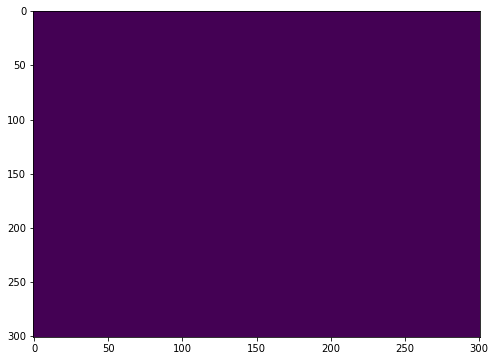

In [5]:
model.draw_model()

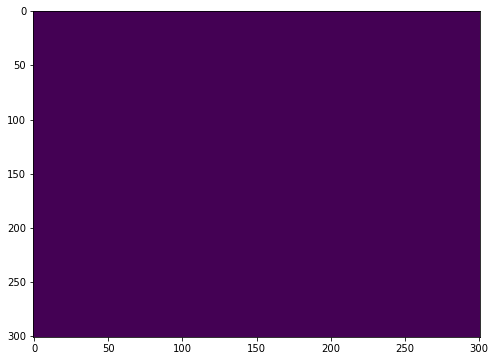

In [6]:
pml_model.draw_model()

In [22]:
older1 = (2, 4)
older2 = (4,10)

coefficient1 = (1.125, -0.04166667)
coefficient2 = (1.211243, -0.08972168, 0.001384277, -0.00176566, 0.0001186795)

space_step = (10,10)

op1 = Operator(older=older1, coefficient=coefficient1, space_step=space_step)
op2 = Operator(older=older2, coefficient=coefficient2, space_step=space_step)

In [23]:
source_position = (150, 150)
total_time = ft
duration = 0.08
fm = 30
direction = 'z'

source = RickerSource(position=source_position, total_time=total_time, duration=duration, fm=fm, direction=direction)

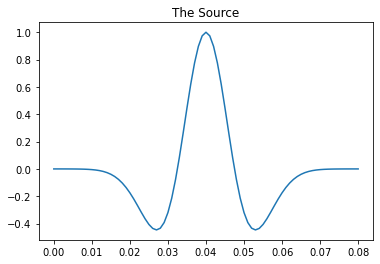

In [24]:
source.draw_wavelet()

In [25]:
receiver_position_x = [i*7+10 for i in range(10)]
receiver_position_z = 10

receivers = [Receiver(total_time=total_time, position=(i,receiver_position_z)) for i in receiver_position_x]

In [26]:
tag = True
solver1 = Solver(model=model, op=op1, source=source, receiver=receivers, ft=ft, tag=tag)
solver2 = Solver(model=model, op=op2, source=source, receiver=receivers, ft=ft, tag=tag)
# solver3 = Solver(model=pml_model, op=op, source=source, receiver=receivers, ft=ft, tag=tag)

In [27]:
solver1.execute()

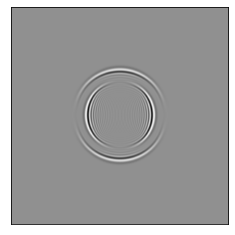

In [36]:
plt.imshow(solver1._vz[:,:,300].T, cmap=plt.cm.gray,
           interpolation='bilinear')
plt.xticks(())
plt.yticks(())
plt.show()

In [29]:
solver2.execute()

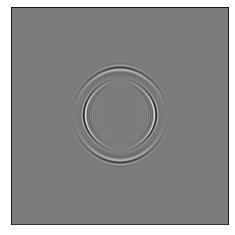

In [37]:
plt.imshow(solver2._vz[:,:,300].T, cmap=plt.cm.gray,
           interpolation='bilinear')
plt.xticks(())
plt.yticks(())
plt.show()

In [198]:
solver3.execute()

here


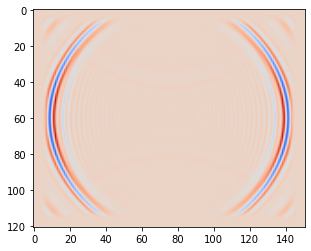

In [202]:
plt.imshow(solver3._vz[:,:,400].T, cmap=plt.cm.coolwarm,
           interpolation='bilinear')
plt.show()